# Analitica de datos

## Proyecto 2020

### Daniel Galvis Torres y Sebastian Arango Vergara

Primero se importan las librerias

In [404]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
import seaborn as sns
import math

from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score #protocolo de evaluaciónw
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, tree,preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Se cargan los datos

In [2]:
df = pd.read_csv('PF-02-DatosTelco.csv',sep=',')
df.head()

ESTADO  INGRESOS          CASA  PRECIO_DISPOSITIVO  MESES  DURACION  \
0  VINCULADO   4074840  8.830000e+08           1444153.0     26       2.3   
1  VINCULADO   8574088  1.745000e+09           2157661.0     23       3.7   
2   RETIRADO    795993  9.500000e+07            452809.0     38      16.8   
3   RETIRADO   8115015  8.300000e+07           2617184.0     37      17.6   
4   RETIRADO   8187499  6.770000e+08            666069.0     19       0.0   

   SOBRECARGO  SALDO_RESTANTE  SATISFACCION  
0   11.167542            20.3      1.762872  
1    0.000000            53.5      3.361266  
2  350.610224            13.9      8.359438  
3  230.913888            45.7      8.964017  
4  131.541983            67.2      8.808206

## Parte 1

# 1. Limpieza de datos

## Identificacion de problemas

### Vistazo general

In [3]:
df.describe(include='all').T

count unique       top   freq         mean          std  \
ESTADO              23162      2  RETIRADO  11665          NaN          NaN   
INGRESOS            23162    NaN       NaN    NaN  4.81312e+06  2.73737e+06   
CASA                23162    NaN       NaN    NaN  7.16144e+08  4.81155e+08   
PRECIO_DISPOSITIVO  23162    NaN       NaN    NaN  1.31534e+06       748570   
MESES               23162    NaN       NaN    NaN      24.1971       14.264   
DURACION            23162    NaN       NaN    NaN      9.60985      7.04001   
SOBRECARGO          23162    NaN       NaN    NaN      110.056      100.772   
SALDO_RESTANTE      23162    NaN       NaN    NaN      42.9919      30.2045   
SATISFACCION        23162    NaN       NaN    NaN      5.48084      2.80994   

                        min         25%          50%          75%       max  
ESTADO                  NaN         NaN          NaN          NaN       NaN  
INGRESOS             150000  2.1563e+06  6.13755e+06  7.34718e+06  9.65e+06  
CASA                  8e+07    3.57e+08     6.24e+08   9.0775e+08  2.18e+09  
PRECIO_DISPOSITIVO   200000      657184  1.23746e+06  1.82958e+06   4.7e+06  
MESES                     0          14           24           34        79  
DURACION                  0         2.1         14.6         16.1      20.1  
SOBRECARGO                0     12.5669      75.3836       201.55   411.168  
SALDO_RESTANTE            0        15.2        37.65           70     130.7  
SATISFACCION        0.61358      2.7055      4.06455      8.26824   9.64262

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23162 entries, 0 to 23161
Data columns (total 9 columns):
ESTADO                23162 non-null object
INGRESOS              23162 non-null int64
CASA                  23162 non-null float64
PRECIO_DISPOSITIVO    23162 non-null float64
MESES                 23162 non-null int64
DURACION              23162 non-null float64
SOBRECARGO            23162 non-null float64
SALDO_RESTANTE        23162 non-null float64
SATISFACCION          23162 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.6+ MB


Podemos notar que no hay ningún valor nulo, por lo que no debemos preocuparnos de ese aspecto.
De igual forma, la variable categórica (Estado) tiene dos únicos valores, lo que también es normal.
Además, ningún valor númerico es menor a 0, por lo que desde este punto de vista no hay ninguna anomalía

### Se pasará a ver la distribución de los datos en las variables numéricas con boxplots:

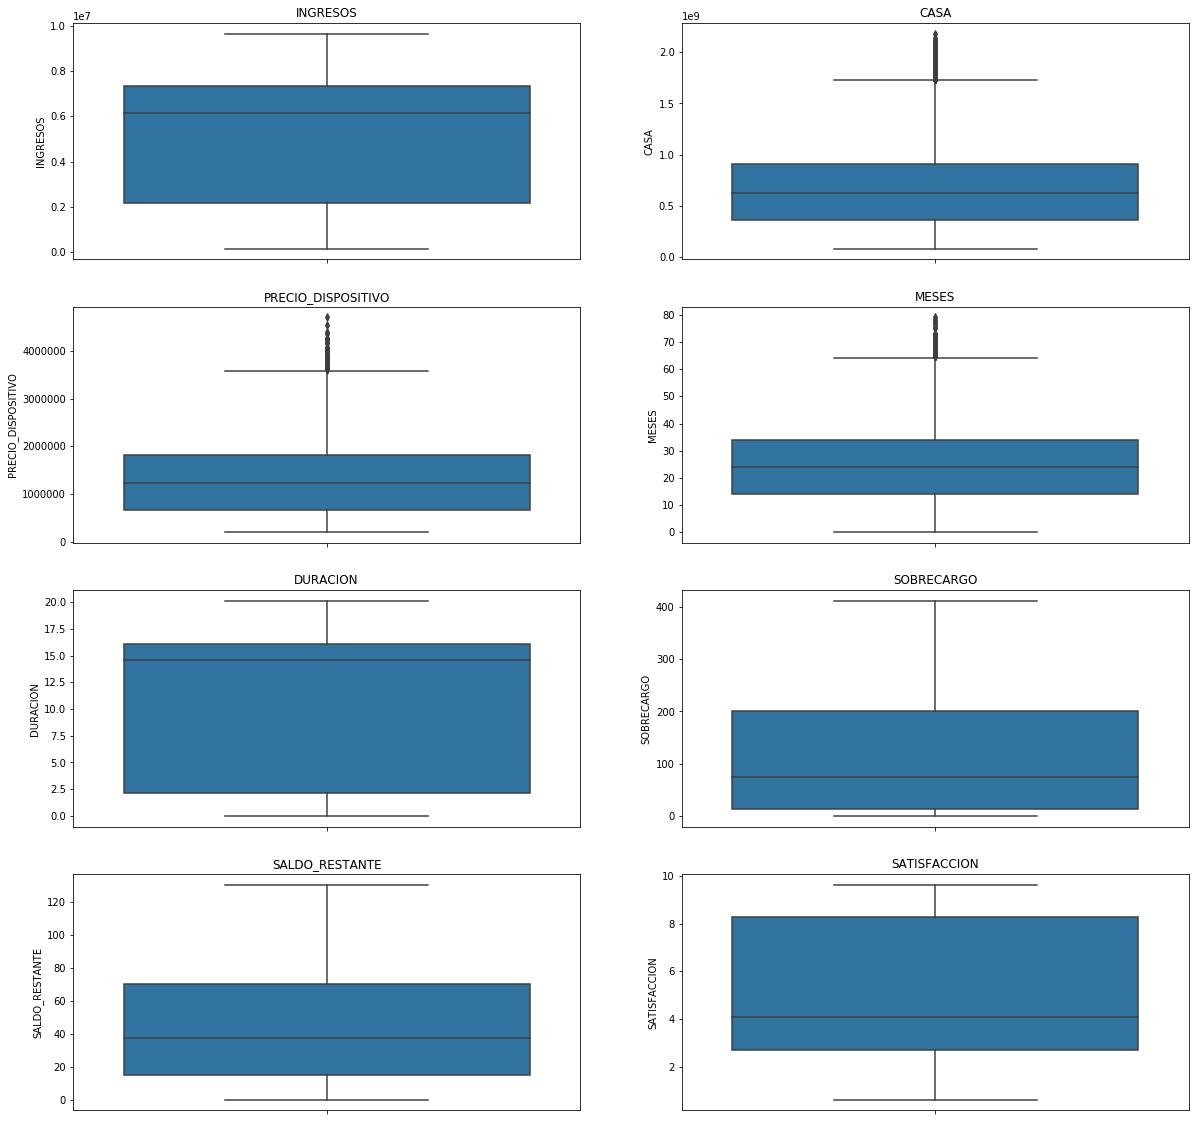

In [5]:
fig = plt.figure(figsize=(20,20))
i=1
for var_num in df.columns[1:]:
    ax = fig.add_subplot(4, 2, i) #Defino una tabla de 2 filas por 1 columnas, agrego el i-ésimo plot
    sns.boxplot(y=var_num, data=df)
    plt.title(var_num)
    i+=1

1. Existen outliers en CASA, PRECIO_DISPOSITIVO y en MESES.
Solo se eliminaran aquellos valores que esten a mas o menos de 4 std del promedio.

In [6]:
upper_bounds={}
lower_bounds={}
for var_num in df.columns[1:]:
    msk=df[var_num]
    upper_bounds[var_num]=msk.mean()+4*msk.std()
    lower_bounds[var_num]=msk.mean()-4*msk.std()
    
for var_num in df.columns[1:]:
    msk=df[var_num]
    print(var_num)
    print(upper_bounds[var_num])
    df=df[msk<=upper_bounds[var_num]]
    df=df[msk>=lower_bounds[var_num]]

INGRESOS
15762611.074484445
CASA
2640764007.1198745
PRECIO_DISPOSITIVO
4309620.34060074


C:\Users\danig\Anaconda3\envs\analitica\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


MESES
81.2531910411397
DURACION
37.76988146479508
SOBRECARGO
513.1423078633344
SALDO_RESTANTE
163.81004697843267
SATISFACCION
16.72058992444451


In [7]:
df=df.reset_index(drop=True)

### Analisis correlación entre variables

In [8]:
preCorr = df.drop(columns="ESTADO")
preCorr.corr()

INGRESOS      CASA  PRECIO_DISPOSITIVO     MESES  \
INGRESOS            1.000000  0.384465           -0.006736 -0.005715   
CASA                0.384465  1.000000            0.001439 -0.002846   
PRECIO_DISPOSITIVO -0.006736  0.001439            1.000000 -0.001461   
MESES              -0.005715 -0.002846           -0.001461  1.000000   
DURACION           -0.158182 -0.063700            0.011556  0.007094   
SOBRECARGO         -0.000666  0.003249            0.005013  0.004717   
SALDO_RESTANTE      0.844883  0.326608           -0.004230 -0.003614   
SATISFACCION        0.002619  0.002450           -0.000413  0.002726   

                    DURACION  SOBRECARGO  SALDO_RESTANTE  SATISFACCION  
INGRESOS           -0.158182   -0.000666        0.844883      0.002619  
CASA               -0.063700    0.003249        0.326608      0.002450  
PRECIO_DISPOSITIVO  0.011556    0.005013       -0.004230     -0.000413  
MESES               0.007094    0.004717       -0.003614      0.002726  
DURACION            1.000000    0.001898        0.046901      0.000928  
SOBRECARGO          0.001898    1.000000        0.002447      0.889806  
SALDO_RESTANTE      0.046901    0.002447        1.000000      0.004330  
SATISFACCION        0.000928    0.889806        0.004330      1.000000

Al analizar la correlación entre variables, podemos encontrar que 2 correlaciones son altas: la correlación entre SALDO_RESTANTE e INGRESOS (0.84) y la correlación entre SATISFACCION y SOBRECARGO (0.89).

Por esto, se puede utilizar PCA para mejorar el analisis posterior al hacer independiente las variables a costa de perder su interpretabilidad.

Se decide cambiar los valores de retirado por 1, y los de vinculado por 0, esto debido a la definicion de positivo y negativo que se dara mas adelante

In [9]:
scaler = StandardScaler(with_mean=True, with_std=True)
pca = PCA()
df_estado=df[['ESTADO']]
df_var=df.drop(columns='ESTADO')
df_norm = pd.DataFrame(pca.fit_transform(scaler.fit_transform(df_var)))
df_pca = pd.concat([df_estado,df_norm],axis=1)
df_pca.loc[df_pca['ESTADO'] == 'RETIRADO', 'ESTADO'] = 1
df_pca.loc[df_pca['ESTADO'] == 'VINCULADO', 'ESTADO'] = 0
df_pca.head()

ESTADO         0         1         2         3         4         5  \
0       0 -0.449363 -1.619763 -0.968673 -0.055228  0.719247  0.486791   
1       0  2.047057 -1.358564 -0.400182 -0.773284  1.216780  1.319316   
2       1 -2.128797  2.474087  0.576179  1.490837 -0.734514 -0.317911   
3       1  0.206507  1.731249  1.894257 -0.216079  1.199616 -1.445801   
4       1  1.428179  0.939120 -1.478062  0.162487 -0.329175 -0.807260   

          6         7  
0  0.125017 -0.244001  
1  0.511066  0.226857  
2 -0.191515 -0.959068  
3  1.046334 -0.001869  
4  0.136936  0.673993

Ahora se quiere analizar la varianza explicada por cada PC.

[0.26109487 0.49730995 0.62534879 0.75051946 0.87461914 0.97007271
 0.98623176 1.        ]


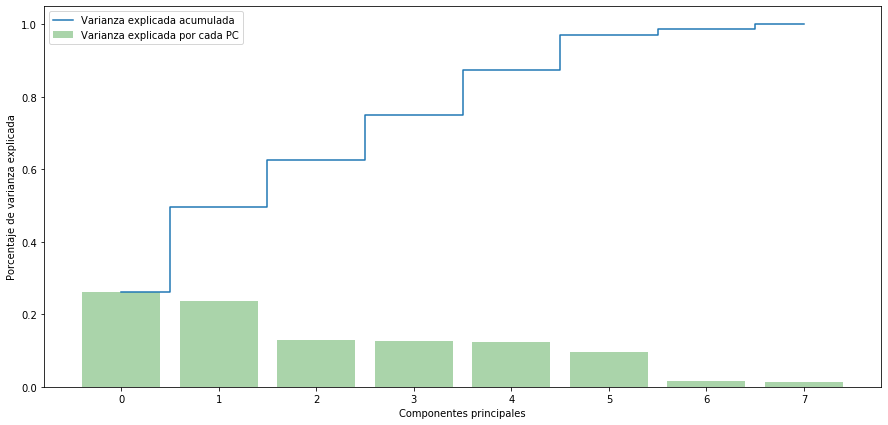

In [11]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
print(cum_var_exp)
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

Podemos ver que con los primeros 6 componentes, ya tenemos casi el 97% de la varianza explicada, por lo tanto, quitaremos los ultimos 2 componentes

In [12]:
df_pca=df_pca.drop(columns=6)
df_pca=df_pca.drop(columns=7)
df_pca.head()

ESTADO         0         1         2         3         4         5
0       0 -0.449363 -1.619763 -0.968673 -0.055228  0.719247  0.486791
1       0  2.047057 -1.358564 -0.400182 -0.773284  1.216780  1.319316
2       1 -2.128797  2.474087  0.576179  1.490837 -0.734514 -0.317911
3       1  0.206507  1.731249  1.894257 -0.216079  1.199616 -1.445801
4       1  1.428179  0.939120 -1.478062  0.162487 -0.329175 -0.807260

Se va a utilizar el protocolo de evaluación Holdout para evaluar los modelos, y el protocolo de k fold cross validation para calibrarlos

In [13]:
data_x=df_pca.drop(columns='ESTADO')
data_y=df_pca[['ESTADO']]
X_train, X_test, y_train, y_test = train_test_split(data_x,data_y.values,
                                                    test_size=0.3,
                                                    random_state=12345,
                                                    stratify=data_y.values)

Antes de establecer las metricas a utilizar, se calcula el accuracy del baseline:

In [14]:
print(df[df['ESTADO']=='RETIRADO'].size/df.size)

0.5036704378616461


Text(0.5, 1.0, 'Sobrecargo vs Satisfacción')

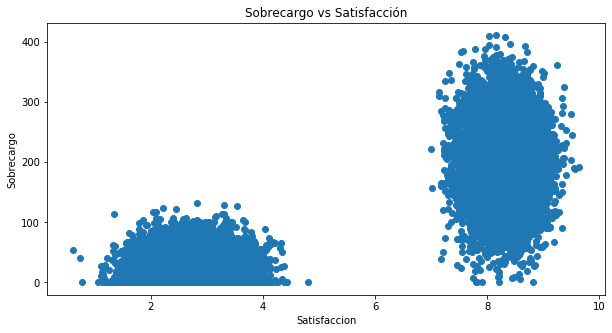

In [35]:
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.scatter(df[['SATISFACCION']], df[['SOBRECARGO']])
plt.xlabel('Satisfaccion')
plt.ylabel('Sobrecargo')
plt.title('Sobrecargo vs Satisfacción')

Se define terminologia: positivo=RETIRADO, negativo=VINCULADO

Se decide utilizar las metricas de accuracy y recall. Accuracy debido a que las dos clases en los datos estan balanceadas, y recall porque es muy importante identificar aquellos clientes en riesgo de retirarse lo mas rapido posible, esto para despues fidelizarlos adecuadamente. 

### Calibración modelos: KNN

(accuracy,recall,k)
(0.905798889574337, 0.9009064725093957, 15)


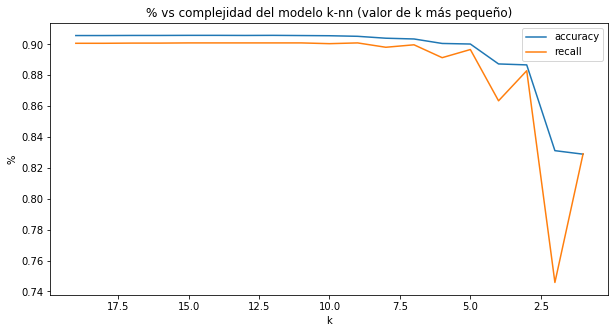

In [15]:
acc_test=[]
recall_test=[]
k_vec= np.arange(1,20,1)
bestK=(-1,-1,-1)
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracies=cross_val_score(knn,X_train,y_train.ravel(),cv=5,scoring='accuracy')
    recalls=cross_val_score(knn,X_train,y_train.ravel(),cv=5,scoring='recall')
    acc_test.append(accuracies.mean())
    recall_test.append(recalls.mean())
    bestK=max(bestK,(acc_test[-1],recall_test[-1],k))
print('(accuracy,recall,k)')
print(bestK)
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.plot(k_vec, acc_test)
plt.plot(k_vec, recall_test)
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('%')
plt.title('% vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['accuracy', 'recall'])

Se decide tomar 15 como valor optimo para k

### Calibración modelos: arbol de decisión

Para calibrar los arboles de decisión, se analizaran individualmente valores de min_samples_split y de min_samples_leaf.

accuracy,recall,MSS
(0.8998149290561382, 0.8961296122858207, 382)


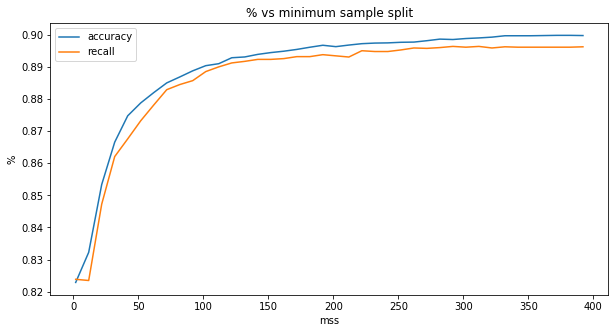

In [16]:
acc_test=[]
recall_test=[]
vec= np.arange(2,400,10)
bestMSS=(-1,-1,-1)
for mss in vec:
    np.random.seed(1234)
    ctree = tree.DecisionTreeClassifier(
        criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
        max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
        min_samples_split=mss, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
        min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
        random_state=None,   # semilla del generador aleatorio utilizado para 
        max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
        min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
        class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
    )
    accuracies=cross_val_score(ctree,X_train,y_train.ravel(),cv=5,scoring='accuracy')
    recalls=cross_val_score(ctree,X_train,y_train.ravel(),cv=5,scoring='recall')
    acc_test.append(accuracies.mean())
    recall_test.append(recalls.mean())
    bestMSS=max(bestMSS,(acc_test[-1],recall_test[-1],mss))
print('accuracy,recall,MSS')
print(bestMSS)
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.plot(vec, acc_test)
plt.plot(vec, recall_test)
plt.axis('tight')
plt.xlabel('mss')
plt.ylabel('%')
plt.title('% vs minimum sample split')
plt.legend(['accuracy', 'recall'])

accuracy,recall,MSL
(0.9044417026526835, 0.8980892709196355, 20)


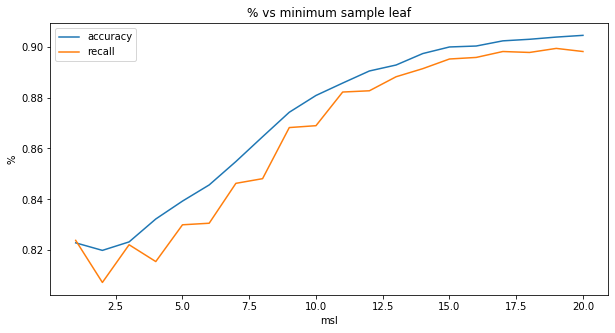

In [17]:
acc_test=[]
recall_test=[]
vec= np.arange(1,21,1)
bestMSL=(-1,-1,-1)
for msl in vec:
    np.random.seed(1234)
    ctree = tree.DecisionTreeClassifier(
        criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
        max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
        min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
        min_samples_leaf=msl,  # prepoda: el mínimo número de registros en una hoja
        random_state=None,   # semilla del generador aleatorio utilizado para 
        max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
        min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
        class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
    )
    accuracies=cross_val_score(ctree,X_train,y_train.ravel(),cv=5,scoring='accuracy')
    recalls=cross_val_score(ctree,X_train,y_train.ravel(),cv=5,scoring='recall')
    acc_test.append(accuracies.mean())
    recall_test.append(recalls.mean())
    bestMSL=max(bestMSL,(acc_test[-1],recall_test[-1],msl))
print('accuracy,recall,MSL')
print(bestMSL)
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.plot(vec, acc_test)
plt.plot(vec, recall_test)
plt.axis('tight')
plt.xlabel('msl')
plt.ylabel('%')
plt.title('% vs minimum sample leaf')
plt.legend(['accuracy', 'recall'])

Al observar los valores optimos de min_samples_split (~382) y min_samples_leaf (~20), se decide hacer un modelo con estos dos valores.

### Calibración modelos: Naive Bayes

accuracy,recall,smoothingVar
(0.9059839605181986, 0.9012739694775644, 20)


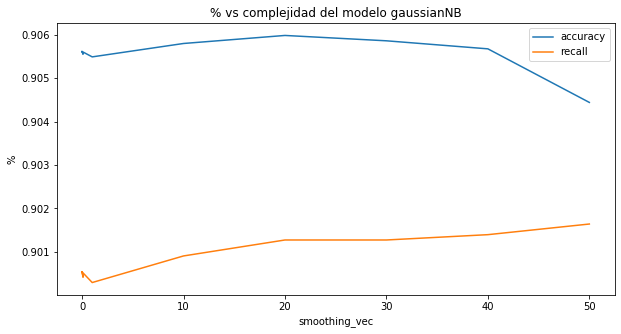

In [18]:
bestSV=(-1,-1,-1)
acc_test=[]
recall_test=[]
smoothing_vec= [1e-100,1e-20,1e-10,1e-9,1e-8,1e-4,1e-2,1e-1,0,1,10,20,30,40,50]
for var in smoothing_vec:
    clf = GaussianNB(var_smoothing=var)
    accuracies=cross_val_score(clf,X_train,y_train.ravel(),cv=5,scoring='accuracy')
    recalls=cross_val_score(clf,X_train,y_train.ravel(),cv=5,scoring='recall')
    acc_test.append(accuracies.mean())
    recall_test.append(recalls.mean())
    bestSV=max(bestSV,(acc_test[-1],recall_test[-1],var))
print('accuracy,recall,smoothingVar')
print(bestSV)
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.plot(smoothing_vec,acc_test)
plt.plot(smoothing_vec,recall_test)
plt.axis('tight')
plt.xlabel('smoothing_vec')
plt.ylabel('%')
plt.title('% vs complejidad del modelo gaussianNB')
plt.legend(['accuracy','recall'])

Podemos observar que el modelo optimo con el gaussianNB, se logra con un smoothing_var de 20

## Evaluación modelos:

In [19]:
print('EVALUACIÓN KNN')
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train,y_train.ravel())
y_pred=knn.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_test,y_pred))
print('Kappa: ',metrics.cohen_kappa_score(y_test,y_pred))
print('Recall: ',metrics.recall_score(y_test,y_pred))
print('Precision: ',metrics.precision_score(y_test,y_pred))
print('F1: ',metrics.f1_score(y_test,y_pred))


print('EVALUACIÓN ARBOL DE DECISIÓN')
np.random.seed(1234)
ctree = tree.DecisionTreeClassifier(
    criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
    min_samples_split=382, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
    min_samples_leaf=20,  # prepoda: el mínimo número de registros en una hoja
    random_state=None,   # semilla del generador aleatorio utilizado para 
    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
    min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
    class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
)
ctree.fit(X_train, y_train.ravel())
y_pred = ctree.predict(X_test)
print('accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Kappa: ',metrics.cohen_kappa_score(y_test,y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test,y_pred))
print('F1: ',metrics.f1_score(y_test,y_pred))

print('EVALUACIÓN NAIVE BAYES')
clf = GaussianNB(var_smoothing=20)
clf.fit(X_train,y_train.ravel())
y_pred=clf.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_test,y_pred))
print('Kappa: ',metrics.cohen_kappa_score(y_test,y_pred))
print('Recall: ',metrics.recall_score(y_test,y_pred))
print('Precision: ',metrics.precision_score(y_test,y_pred))
print('F1: ',metrics.f1_score(y_test,y_pred))

EVALUACIÓN KNN
Accuracy:  0.9052964881980426
Kappa:  0.8105978728291054
Recall:  0.9005714285714286
Precision:  0.9104563835932987
F1:  0.9054869290433784
EVALUACIÓN ARBOL DE DECISIÓN
accuracy:  0.905440414507772
Kappa:  0.810885310600862
Recall:  0.9008571428571429
Precision:  0.9104822408316489
F1:  0.9056441189142612
EVALUACIÓN NAIVE BAYES
Accuracy:  0.905440414507772
Kappa:  0.810885310600862
Recall:  0.9008571428571429
Precision:  0.9104822408316489
F1:  0.9056441189142612


Originalmente vemos las metricas de accuracy y recall, pero encontramos que los modelos de arbol de decisión y naive bayes ademas de tener los mismos valores en esas dos metricas, en otras metricas (kappa,precision,f1) tambien resultan ser iguales.
Por lo que podriamos elegir cualquier de los dos ultimos dos modelos, ya que los dos superan al de KNN y tienen un igual desempeño con respecto a las metricas analizadas.

## Parte 2

# Extracción e interpretación de Componentes Principales

Primero, se crea otro DataFrame, que será una copia del DataFrame original pero solo con la información de los clientes retirados. Una vez realizada esta copia, se elimina la columna Estado

In [252]:
df_ret = df[df['ESTADO'] == 'RETIRADO']
df_ret = df_ret.drop('ESTADO', axis=1)
df_ret

INGRESOS         CASA  PRECIO_DISPOSITIVO  MESES  DURACION  SOBRECARGO  \
2        795993   95000000.0            452809.0     38      16.8  350.610224   
3       8115015   83000000.0           2617184.0     37      17.6  230.913888   
4       8187499  677000000.0            666069.0     19       0.0  131.541983   
6       7256758  712000000.0           3493707.0     20      14.8  217.322554   
7       3262245  684000000.0            985708.0     32       1.3  275.595131   
...         ...          ...                 ...    ...       ...         ...   
23145   6891205  462000000.0            376963.0     42      17.4  266.344600   
23149    534323  127000000.0           3144722.0      2      15.1    0.000000   
23151   2879014  329000000.0           1518581.0     22       2.1  176.444400   
23153    473169   99000000.0           1128088.0     28      14.9  153.900600   
23155   7523054  446000000.0            296138.0      6      17.8  290.730900   

       SALDO_RESTANTE  SATISFACCION  
2                13.9      8.359438  
3                45.7      8.964017  
4                67.2      8.808206  
6                69.5      8.285137  
7                19.0      8.040629  
...               ...           ...  
23145            68.4      8.039179  
23149            16.8      3.331059  
23151            10.9      7.973555  
23153            18.6      8.359296  
23155            58.9      8.510907  

[11664 rows x 8 columns]

Veamos cómo se ven los datos extraídos, sin normalizar ni separar en cluster, para hacernos una mejor idea sobre las decisiones a tomar. Para eso, primero se extraerán los componentes principales.

In [253]:
pca = PCA()
df_proyectado = pd.DataFrame(pca.fit_transform(df_ret))

Veamos la varianza explicada por cada componente resultante:

In [254]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
var_exp

array([9.99969953e-01, 2.76564087e-05, 2.39066729e-06, 2.59868168e-14,
       1.16411041e-15, 8.74808600e-16, 1.79879271e-16, 6.64807088e-18])

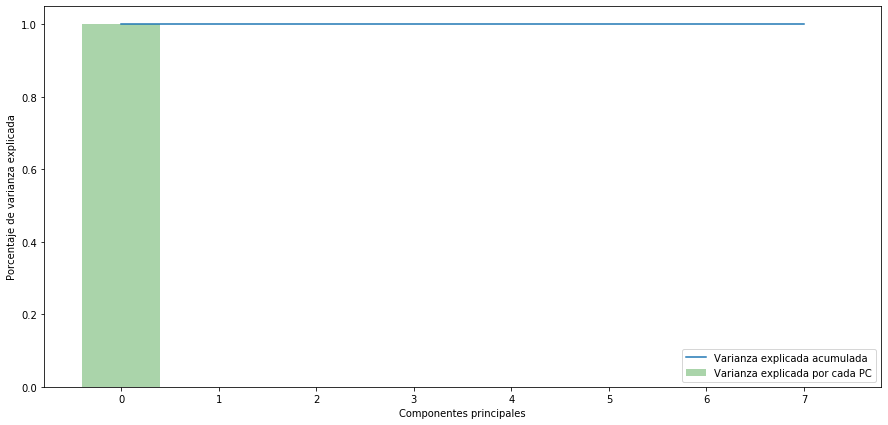

In [255]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

El primer componente explica prácticamente el 100% de la varianza, lo que es un problema y definitivamente es necesario normalizar:

In [381]:
scaler = StandardScaler(with_mean=True, with_std=True)
df_ret_std = scaler.fit_transform(df_ret)

In [382]:
pca = PCA()
df_ret_vec = pca.fit_transform(df_ret_std)
df_ret_proyectado = pd.DataFrame(df_ret_vec)

In [383]:
pca.explained_variance_ratio_

array([0.26062227, 0.21028733, 0.12918762, 0.12482655, 0.12300728,
       0.09615756, 0.03964466, 0.01626675])

In [384]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
cum_var_exp

array([0.26062227, 0.47090959, 0.60009721, 0.72492376, 0.84793104,
       0.94408859, 0.98373325, 1.        ])

In [385]:
df_ret.columns

Index(['INGRESOS', 'CASA', 'PRECIO_DISPOSITIVO', 'MESES', 'DURACION',
       'SOBRECARGO', 'SALDO_RESTANTE', 'SATISFACCION'],
      dtype='object')

In [417]:
pca.components_

array([[ 6.48308470e-01,  4.19025136e-01, -1.64632260e-02,
        -1.36863842e-02, -8.64779733e-02,  3.64005984e-02,
         6.26669981e-01,  4.62276846e-02],
       [ 4.10794460e-02,  1.21082945e-02, -2.43906485e-02,
        -2.80567228e-02, -1.76930060e-02, -7.05910273e-01,
         3.87010612e-02, -7.04743682e-01],
       [-2.93427599e-02,  3.74944512e-03,  5.38580408e-01,
         2.21675220e-01,  7.96018567e-01, -1.54740782e-02,
         1.59417957e-01, -2.48413678e-02],
       [ 7.91517355e-03, -2.98567397e-03, -3.40299679e-01,
         9.39554378e-01, -3.22659953e-02, -8.93771645e-03,
         2.58379174e-03, -1.53127781e-02],
       [ 1.77041562e-02,  7.21576283e-02,  7.68041560e-01,
         2.58639805e-01, -5.68669277e-01, -3.45487800e-03,
        -1.17291981e-01, -2.33101141e-02],
       [-2.63916265e-01,  9.03677971e-01, -5.66633647e-02,
        -1.16823031e-02,  9.10300896e-02, -3.36256190e-03,
        -3.19181420e-01, -1.38763928e-02],
       [-3.24674236e-03,  4.604816

In [387]:
def biplot(data, loadings, index1, index2, labels=None):
    plt.figure(figsize=(15, 7))
    xs = data[:,index1]
    ys = data[:,index2]
    n=loadings.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, loadings[i,index1], loadings[i,index2],color='r',alpha=0.5)
        if labels is None:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(index1))
    plt.ylabel("PC{}".format(index2))
    plt.grid() 

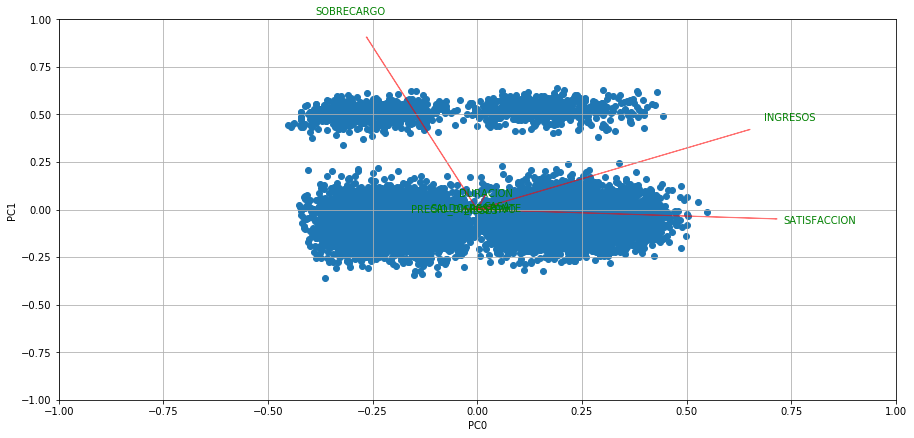

In [388]:
biplot(df_ret_vec[:, 0:5], pca.components_, 0, 1, df_ret.columns)

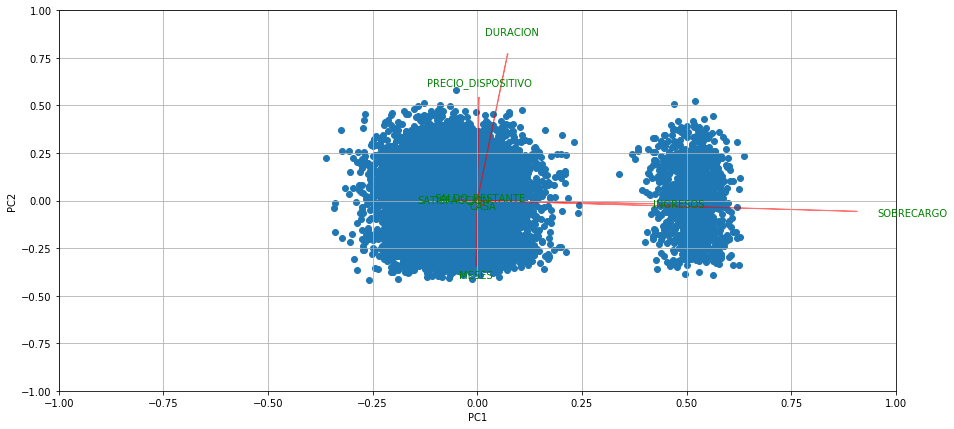

In [389]:
biplot(df_ret_vec[:, 0:5], pca.components_, 1, 2, df_ret.columns)

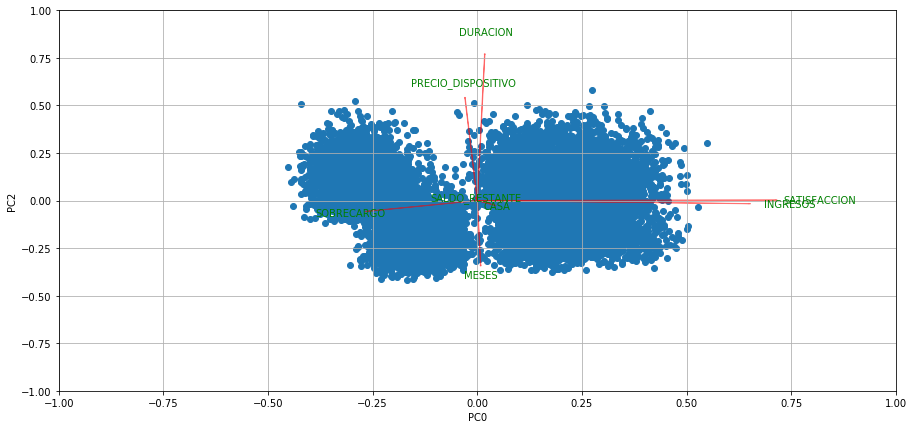

In [390]:
biplot(df_ret_vec[:, 0:5], pca.components_, 0, 2, df_ret.columns)

El primer componente principal está determinado principalmente por los Ingresos y la Satisfacción (Positivamente) y el sobrecargo (Negativamente)

El segundo componente principal está determinado principalmente por el Sobrecargo y los Ingresos (Positivamente)

El tercer componente principal está determinado principalmente por el Precio del Dispositivo y la duración promedio de las llamadas (Positivamente) y la antiguedad del Usuario (Negativamente)

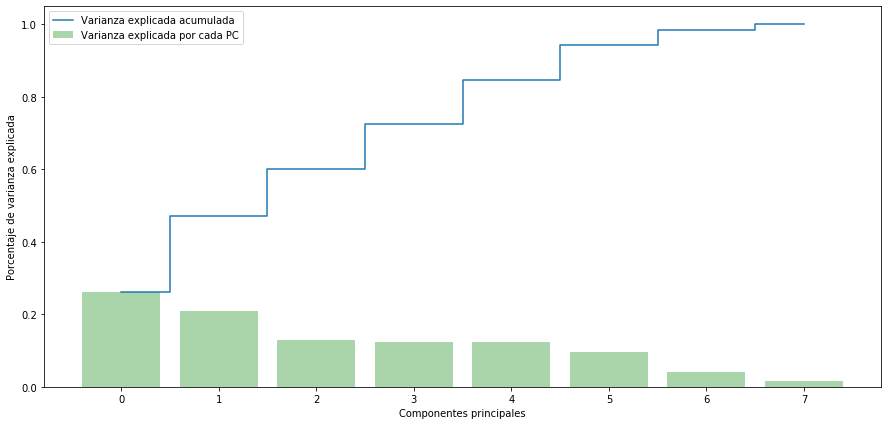

In [391]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

Vemos que con los datos estandarizados los componentes son mucho más razonables. Entre los dos primeros componentes se explica casi el 50% de la varianza, mientras que si le agregamos el tercero se llega al 60%. Entre los 5 primeros, se logra explicar casi el 95% de a varianza, por lo que usaremos únicamente estos 5.

In [392]:
#df_ret_proyectado=df_ret_proyectado.drop(columns=6)
#df_ret_proyectado=df_ret_proyectado.drop(columns=7)
#df_ret_proyectado.head()
df_ret_proyectado_drop_cols = df_ret_proyectado.drop(columns={5,6,7})
df_ret_proyectado_drop_cols.columns = ['PODER_ADQUISITIVO','IMAGEN_COMPAÑIA','IMPORTANCIA_CELULAR','3','4']
df_ret_proyectado_drop_cols

PODER_ADQUISITIVO  IMAGEN_COMPAÑIA  IMPORTANCIA_CELULAR         3  \
0              -2.082807        -1.918666             0.249277  1.236810   
1               0.200486        -1.001930             1.993164  0.210554   
2               1.405073         0.153252            -1.551996  0.007057   
3               1.043159        -0.551730             2.197294 -1.294773   
4              -0.740159        -1.012760            -1.189506  0.684243   
...                  ...              ...                  ...       ...   
11659           0.748413        -0.856416             0.570235  1.565053   
11660          -2.362106         3.341538             1.604921 -2.274308   
11661          -1.367545        -0.108283            -0.889666 -0.209906   
11662          -2.132766        -0.126554             0.434244  0.299657   
11663           0.743405        -1.204247            -0.071616 -0.779725   

              4  
0     -1.239715  
1      0.828858  
2     -0.073134  
3      1.657209  
4      0.547105  
...         ...  
11659 -1.402190  
11660  1.096713  
11661  0.831363  
11662 -0.582082  
11663 -2.140503  

[11664 rows x 5 columns]

## K-Means

Para el análisis con K-Means, se probará separar en 3, 4 y 5 categorías. Para cada categoría se graficará tanto la distribución de cada grupo en cada componente principal, así como un scatter plot contrastando los 3 primeros componentes principales. A partir de lo que se puede inferir, y con ayuda de los métodos vistos en clase, se escogerá el K más conveniente a usar con este método.

In [393]:
WSS = []
CHs = []
clusters = []
def do_kmeans(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(data)
    WSS.append(kmeans.inertia_)
    clusters.append(kmeans.labels_)
    if k > 1:
        CH = calinski_harabaz_score(data, kmeans.labels_)
        CHs.append(CH)
    data.loc[:,'Cluster'] = kmeans.labels_
    return data

In [394]:
def plot_clusters_1D(data,k,var_num):
    fig = plt.figure(figsize=(18,15))
    colors = ['r','g','b','y','m']
    i=1
    for var in var_num:
        ax = fig.add_subplot(math.ceil(len(var_num)/2), 2, i)
        for clust in range(0,k):
            sns.kdeplot(data.loc[data.Cluster==clust][var], shade=True, color=colors[clust], ax=ax);
        plt.title(var)
        plt.legend(['Cluster ' + str(clus) for clus in range(0,k) ])
        i+=1   

In [395]:
def plot_clusters_2D(data, vars, x, y, k):
    fig = plt.figure(figsize=(15,15))
    colorPalette = ["r", "g", "b", "y", "m"][0:k]
    i = 1
    for a in range(0,len(vars)):
        var = vars[a]
        for b in range(a+1, len(vars)) :
            var2 = vars[b]
            ax = fig.add_subplot(x, y, i)
            sns.scatterplot(x=var, y=var2, hue="Cluster", data=data, ax=ax, palette=colorPalette, s=100, alpha=0.5)
            plt.title(var +  " vs " + var2)
            i += 1
            
    plt.show()
    

In [396]:
def plot_silhouete(k):
    y_clusters = clusters[k-1]
    cluster_labels = np.unique(y_clusters)

    silueta_puntos= silhouette_samples(df_ret_proyectado_drop_cols, y_clusters, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    colores = ['r', 'g', 'b', 'y', 'm']
    for i, c in enumerate(cluster_labels):
        silueta_puntos_c = silueta_puntos[y_clusters == c]
        silueta_puntos_c.sort()
        y_ax_upper += len(silueta_puntos_c)
        color = colores[i]
        plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(silueta_puntos_c)

    silueta_promedio = np.mean(silueta_puntos)
    plt.axvline(silueta_promedio, color="black", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Coeficiente de silueta')

    plt.tight_layout()
    # plt.savefig('./figures/silhouette.png', dpi=300)
    plt.show()

In [397]:
var_num = ['PODER_ADQUISITIVO','IMAGEN_COMPAÑIA','IMPORTANCIA_CELULAR', '3', '4']
df_ret_proyectado_drop_cols.loc[:,'IMAGEN_COMPAÑIA'] = -df_ret_proyectado_drop_cols.loc[:,'IMAGEN_COMPAÑIA']

K = 3


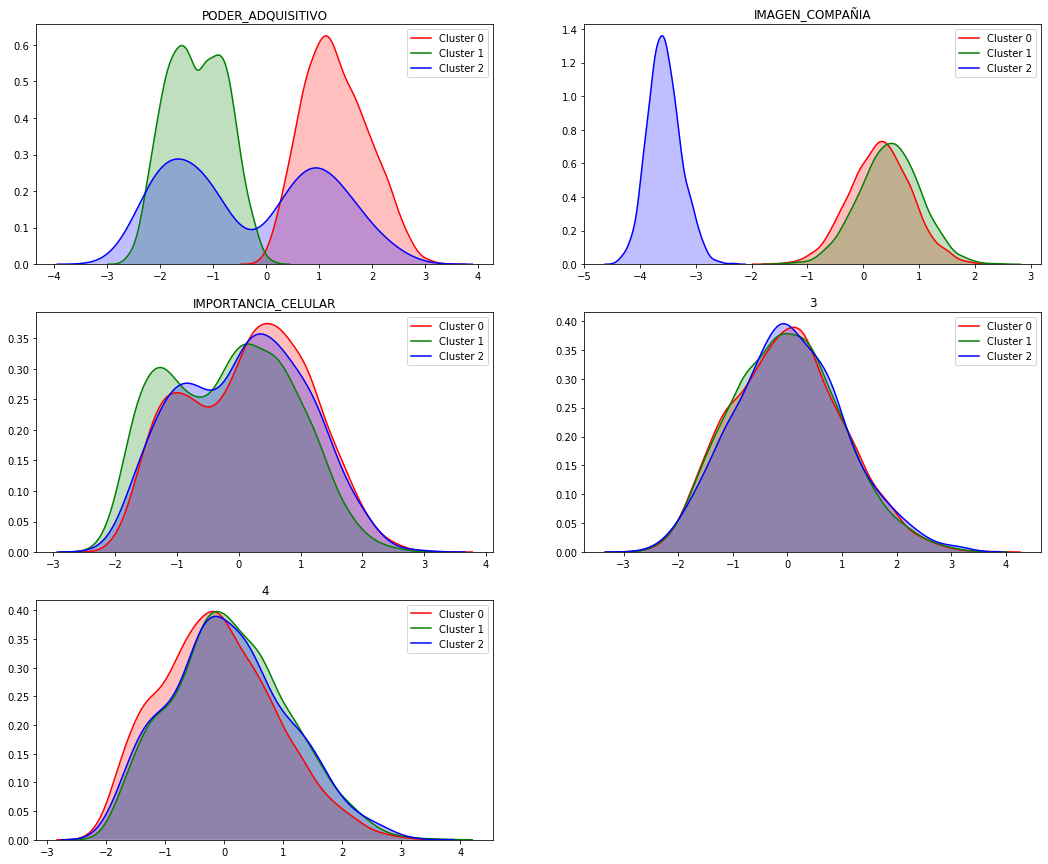

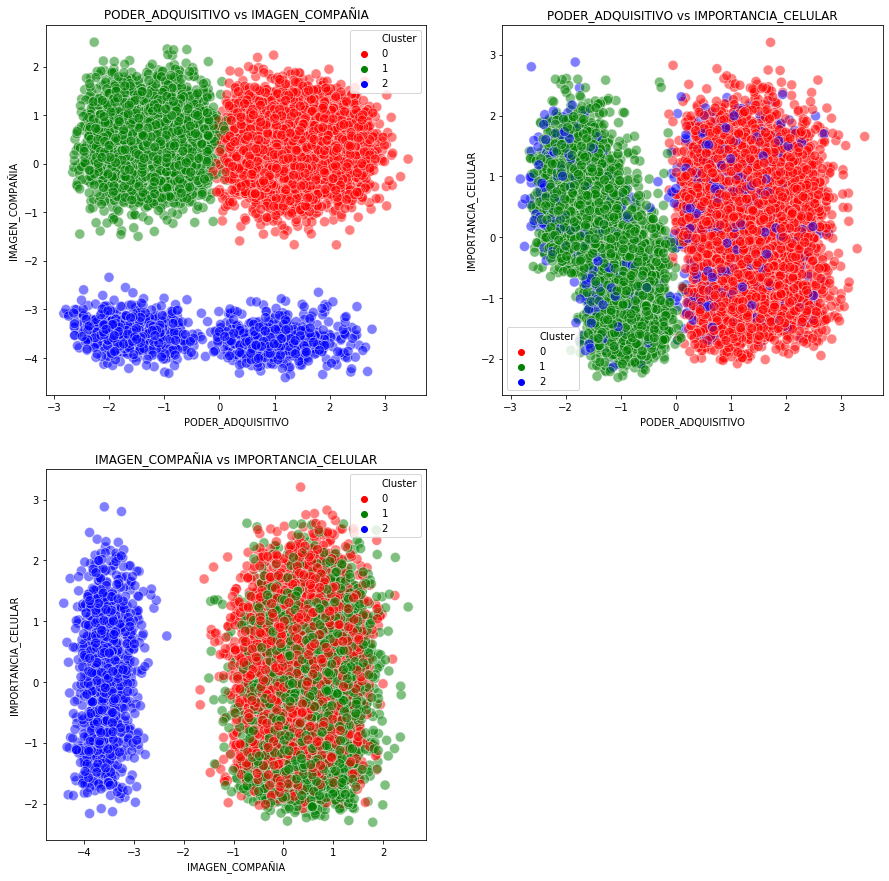

K = 4


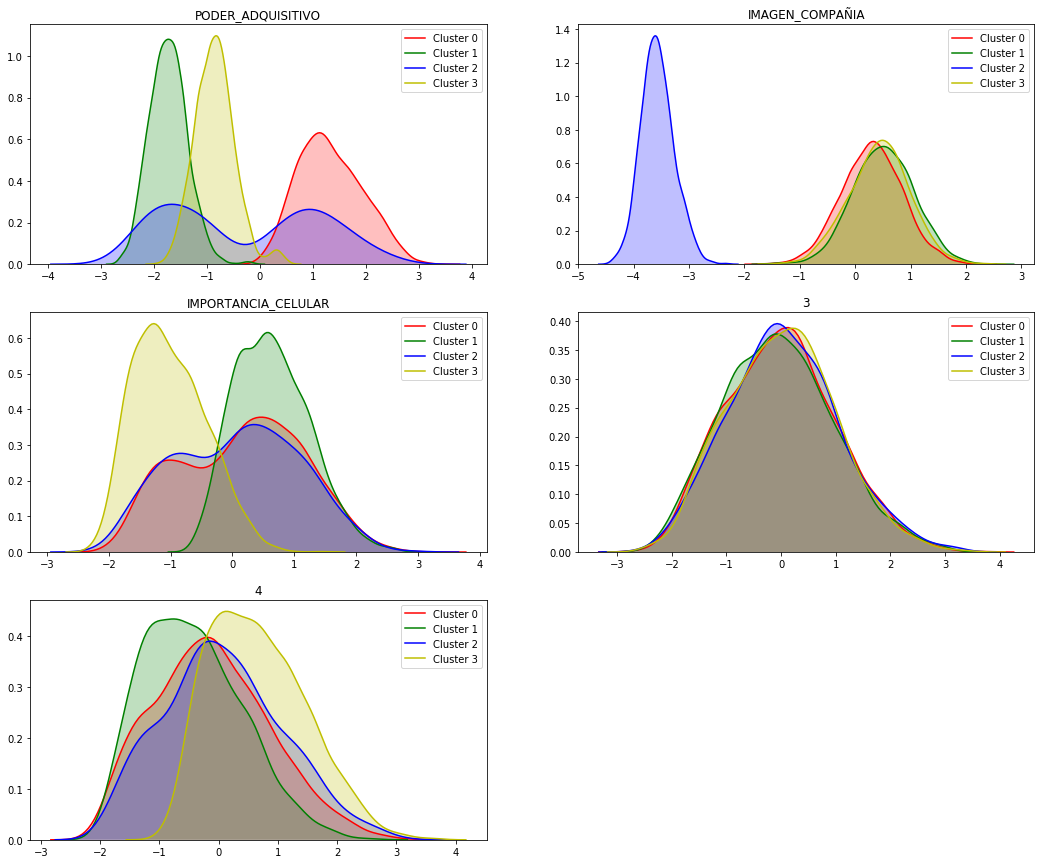

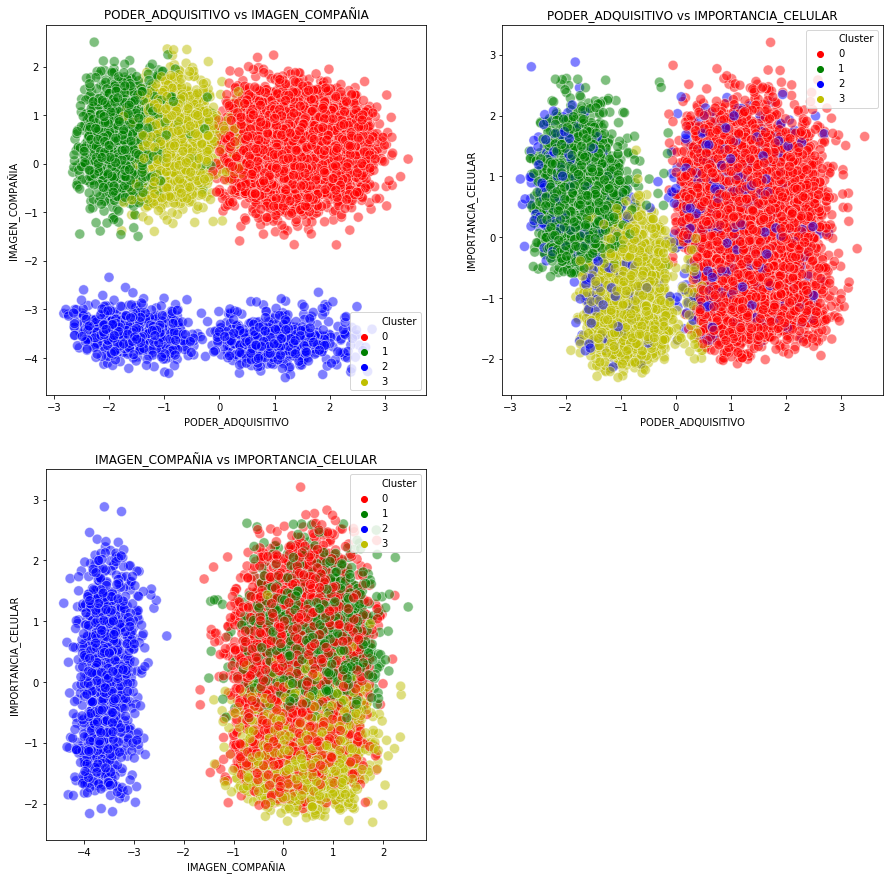

K = 5


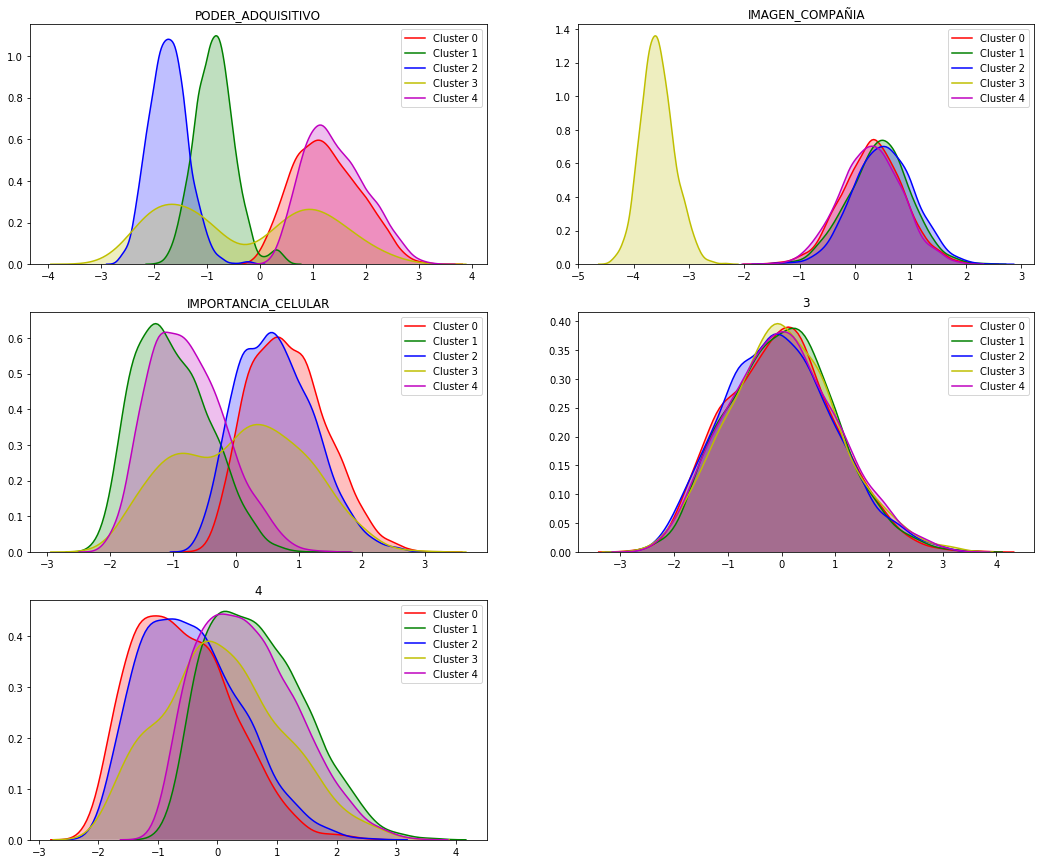

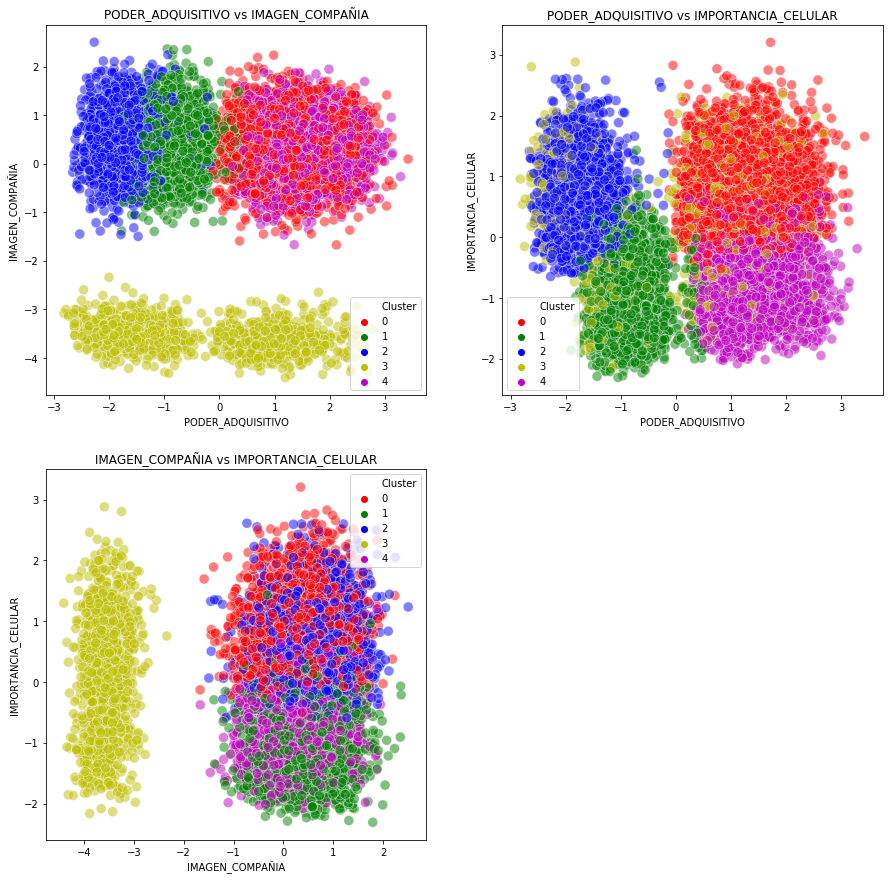

In [398]:
for k in range(1,11):
    act_kmean = do_kmeans(df_ret_proyectado_drop_cols, k)
    if k >= 3 and k <= 5:
        print ("K = " + str(k))
        plot_clusters_1D(df_ret_proyectado_drop_cols, k, var_num)
        plot_clusters_2D(df_ret_proyectado_drop_cols, ['PODER_ADQUISITIVO','IMAGEN_COMPAÑIA','IMPORTANCIA_CELULAR'],2,2,k)

Vemos que para cualquier K, hay un grupo claramente identificable dado por el segundo componente principal (PC1). Sin embargo, los demás componentes entrán en juego para los demás grupos. En el caso de K=3, únicamente separando los restantes entre los que están por encima y por debajo del promedio es suficiente para separarlos en 2 y así tener 3 grupos

Con K = 4, sacar los 3 grupos restantes es algo más difícil viendo unicamente los dos primeros componentes principales: El cluster rojo parece comibinarse con el cluster amarillo. Al comparar con el tercer componente principal también, parece más fácil separarlos a través de una línea diagonal.

Con K = 5, los 4 grupos restantes también parece que se pueden separar al comparar el primer y tercer componente principal: el tercer grupo resulta de la separación en dos de aquellos que su valor del primer componente principal está encima del promedio. Sin embargo, los clusters amarillo y azul parecen mezclarse en cierto rango, y al menos en 2 dimensiones es difícil encontrar una imagen que haga clara la distinción de la frontera

A ojo, pareciera que la mejor decisión es escoger k=3 o k=4, pero usemos la ayuda de algunos de los métodos vistos en clase.

Tecnica del Codo:


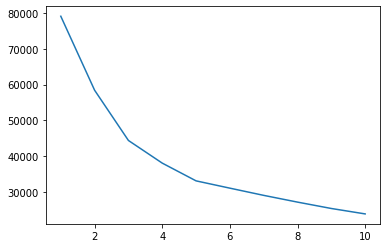

In [399]:
print('Tecnica del Codo:')
plt.plot(range(1,11), WSS)

El codo se marca en K = 3 aproximadamente

Calinski-Harabasz


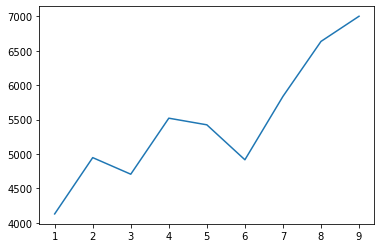

In [402]:
print('Calinski-Harabasz')
plt.plot(range(1, 10), CHs)

Esta métrica nos indica todo lo contrario de la técnica del codo: k = 3 da el peor resultado. Basandonos en este métrica, la mejor opción en [3, 5] es escoger k = 4

Silueta


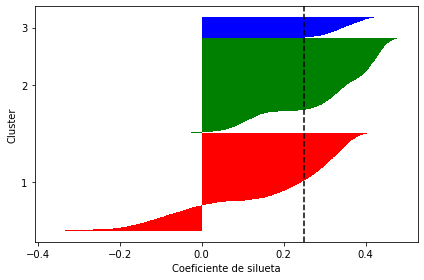

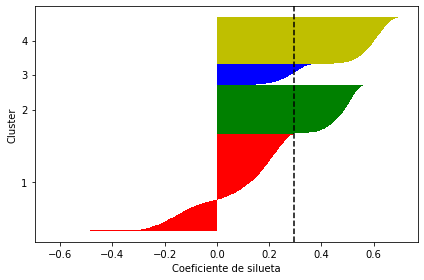

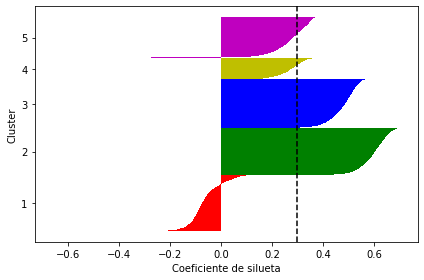

In [403]:
print('Silueta')
plot_silhouete(3)
plot_silhouete(4)
plot_silhouete(5)

En el caso de la silueta, k = 3, 4 y 5 dan valores muy aproximados como promedio.

Así, teniendo en cuenta los resultados de las métricas y la interpretabilidad que se puede dar usando gráficos de 2 dimensiones, se escoge k = 4, debido a que se comporta bien para todas las métricas y es fácil identificar sus clusters con las gráficas de arriba.

## Clustering Jerárquico

In [405]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')

In [419]:
X = df_ret_proyectado_drop_cols
methods = ['ward','complete','average','single','centroid','weighted']
all_fusiones = {link: linkage(X,link) for link in methods}

In [426]:
def draw_dendogram(link, max_d):
    fig, axes = plt.subplots(figsize=(15,6))
    fusiones = all_fusiones[link]
    fancy_dendrogram(
        fusiones,
        truncate_mode='lastp',
        p=50,
        leaf_rotation=90.,
        leaf_font_size=10.,
        show_contracted=True,
        max_d = max_d
    )
    plt.title(link)
    plt.show()

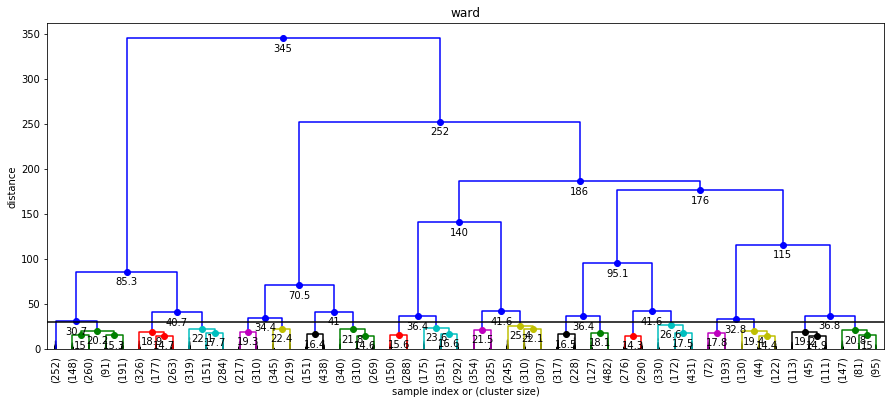

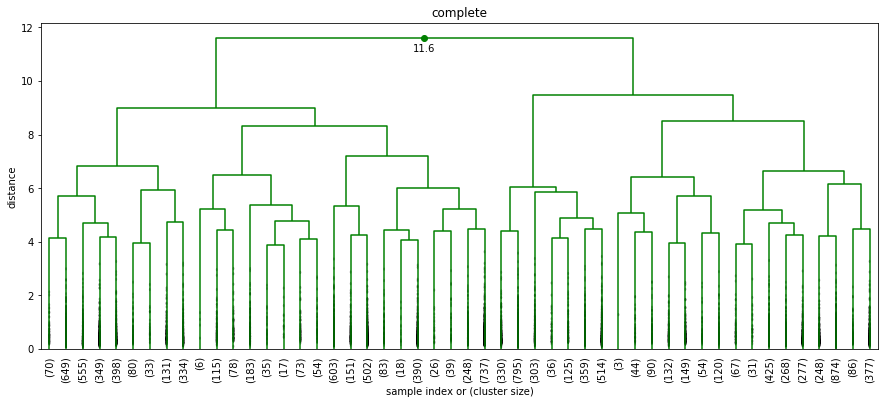

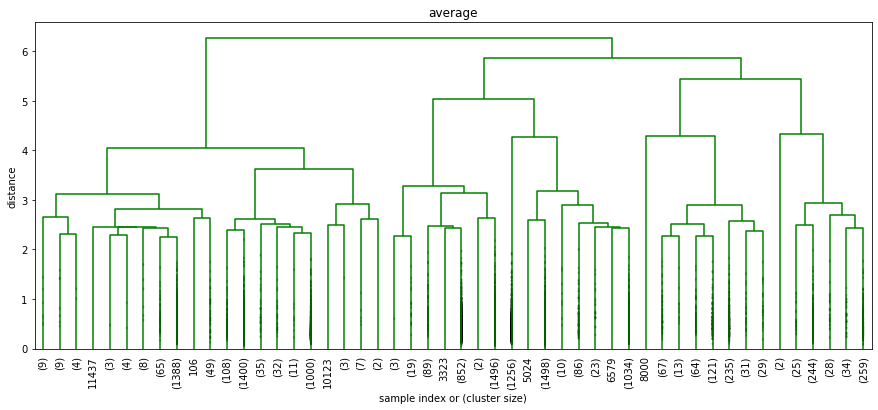

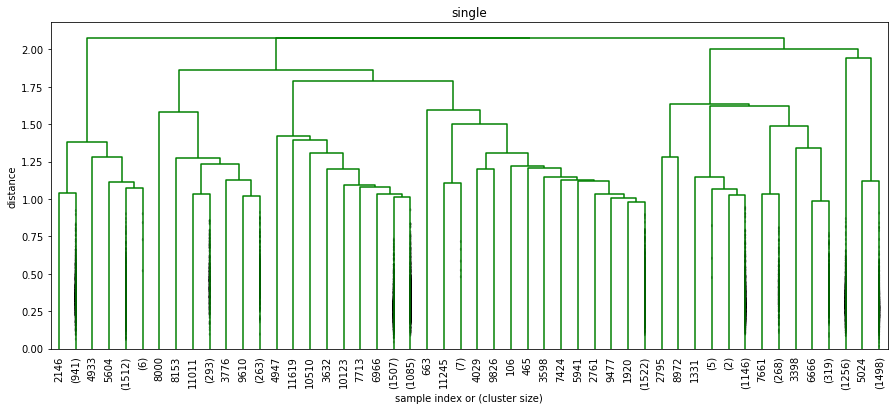

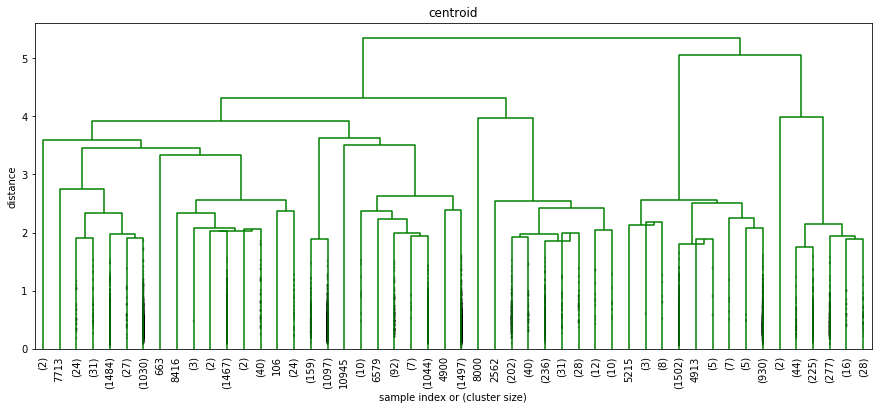

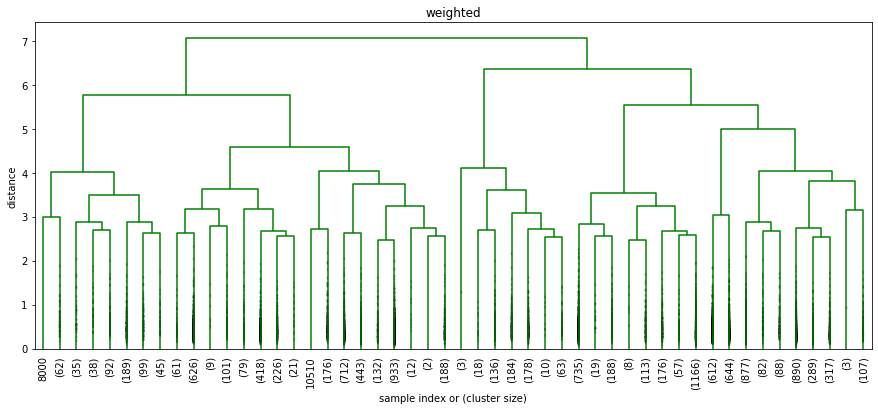

In [425]:
for link in all_fusiones.keys():
    draw_dendogram(link)

In [439]:
def clusterize(link, k, data):
    clusters = fcluster(all_fusiones[link], k, criterion='maxclust')
    data.loc[:,'Cluster'] = clusters-1
    return data

ward


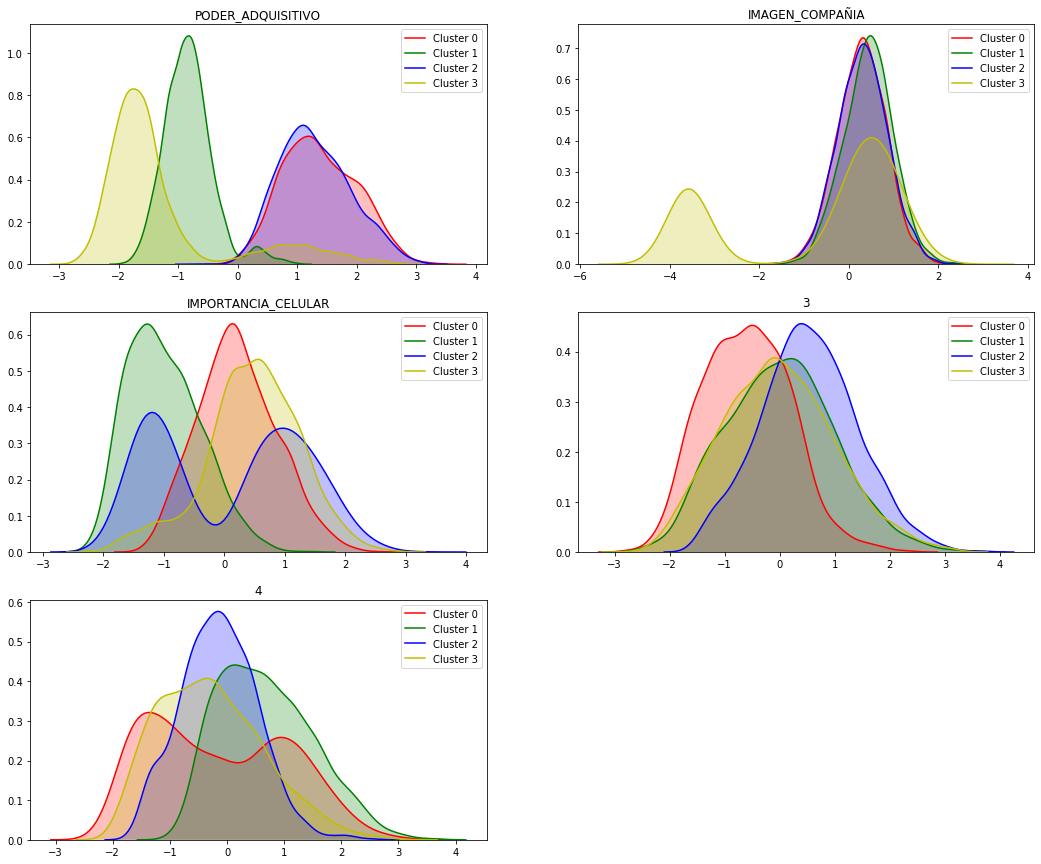

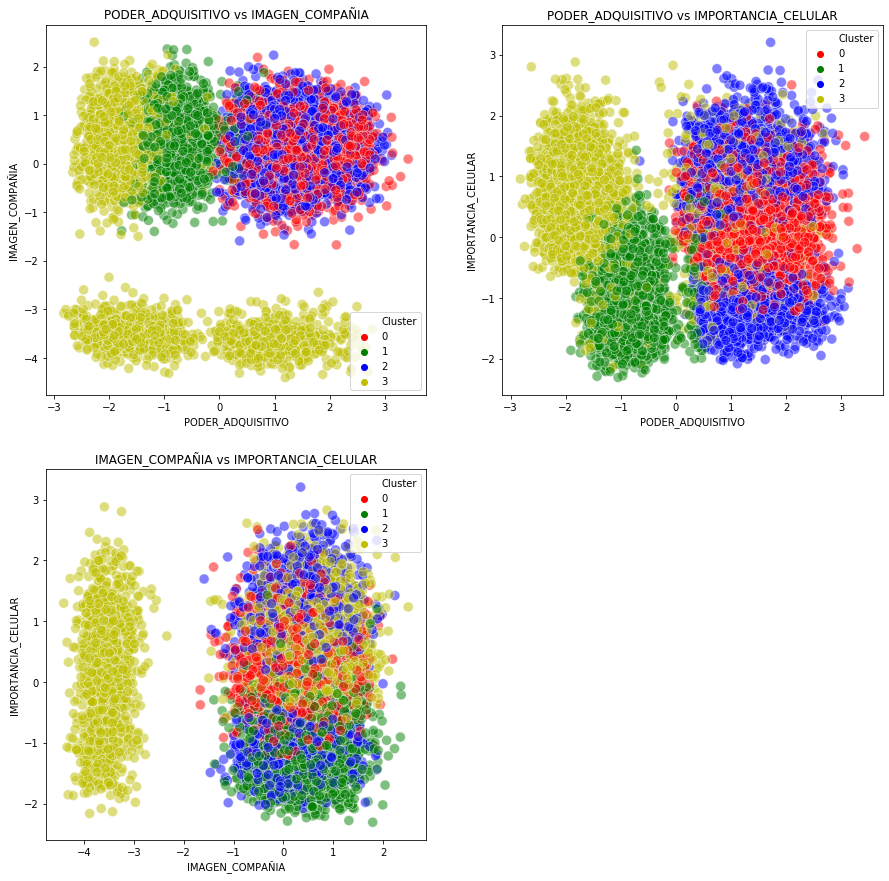

complete


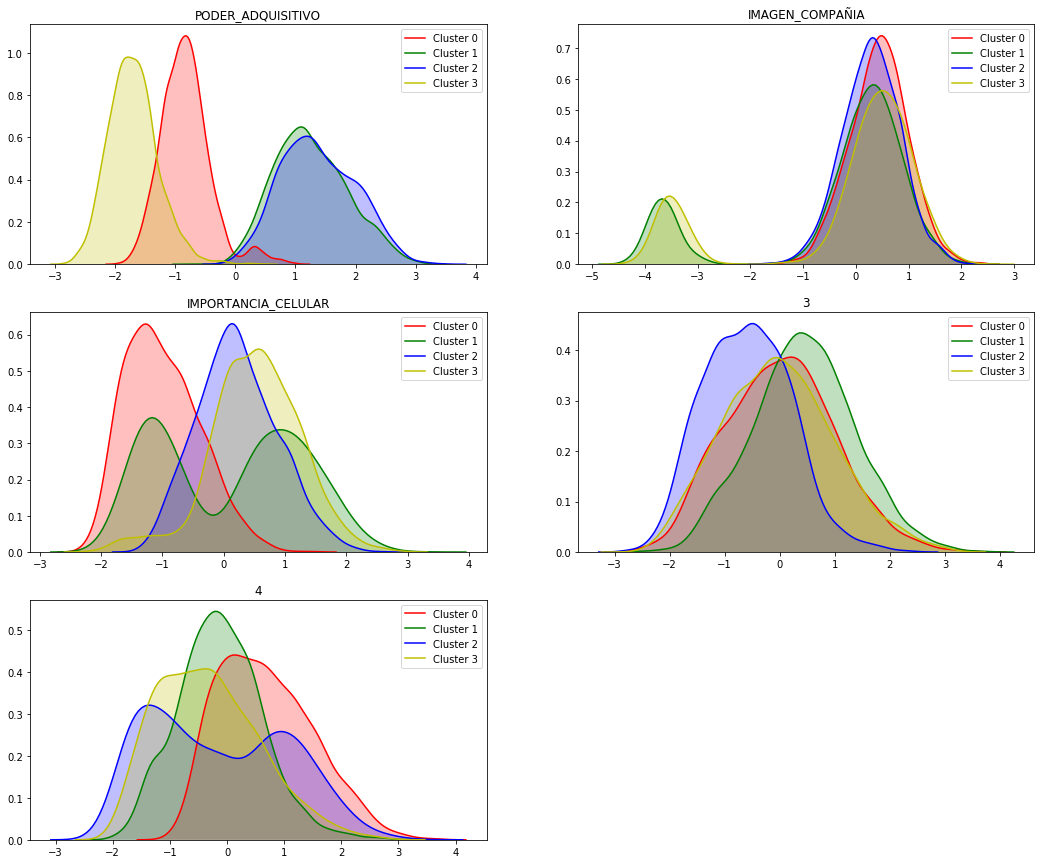

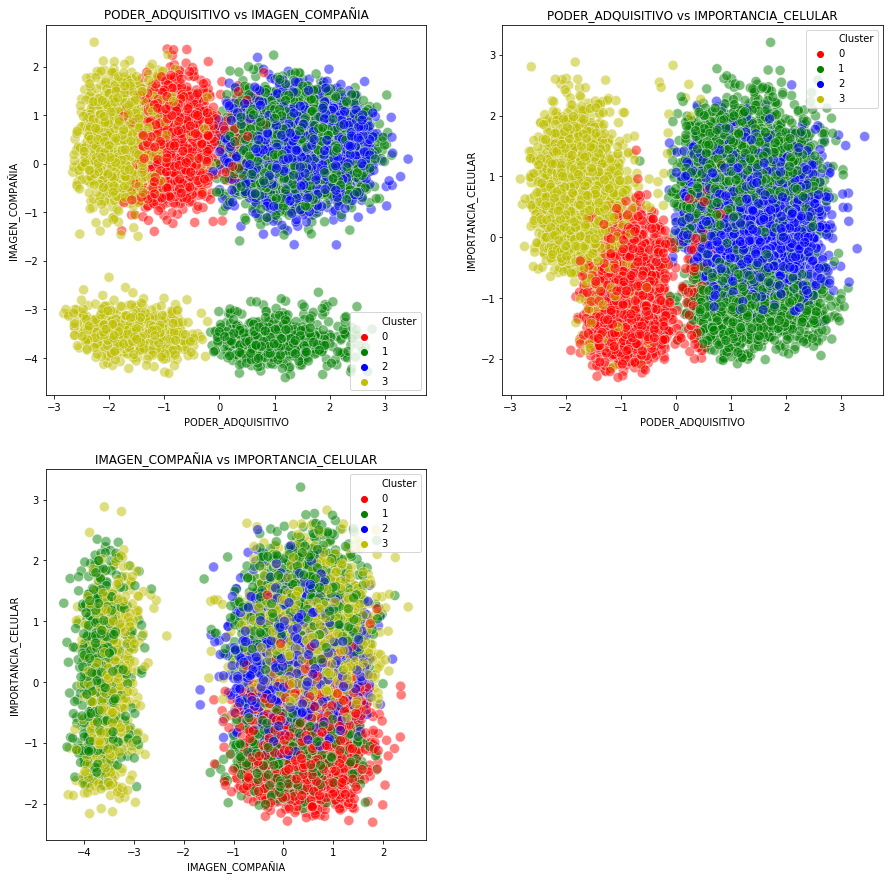

average


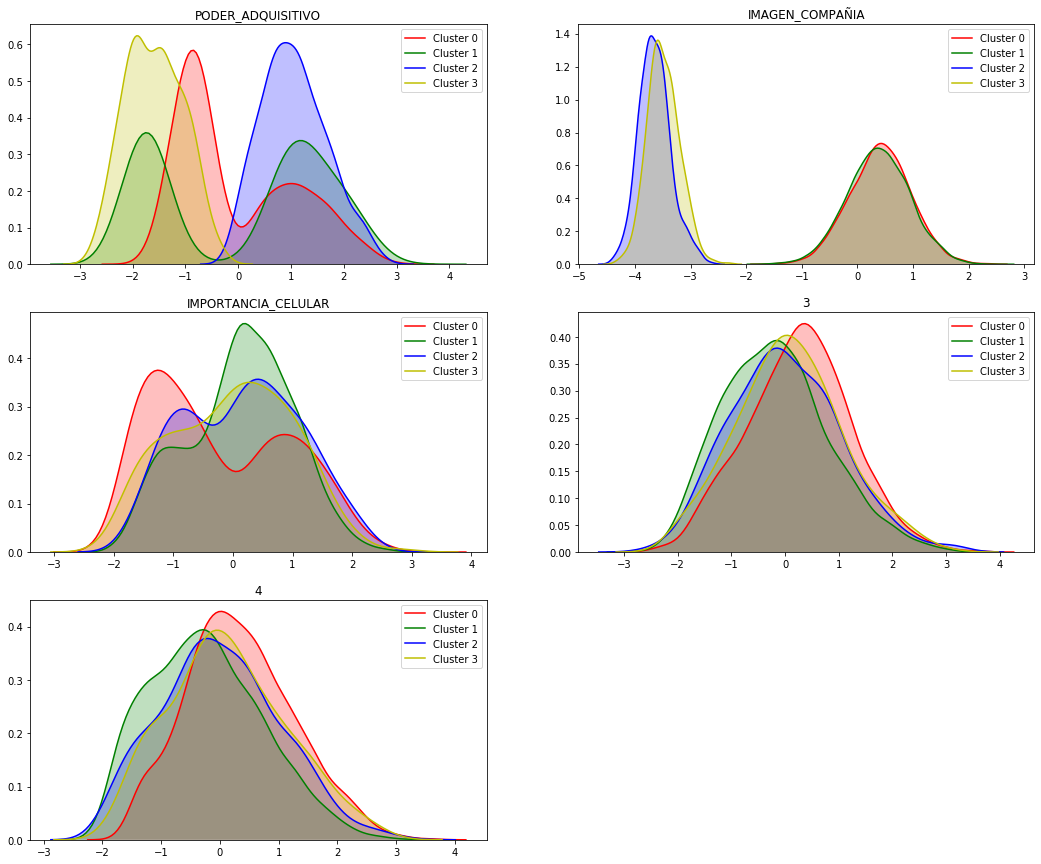

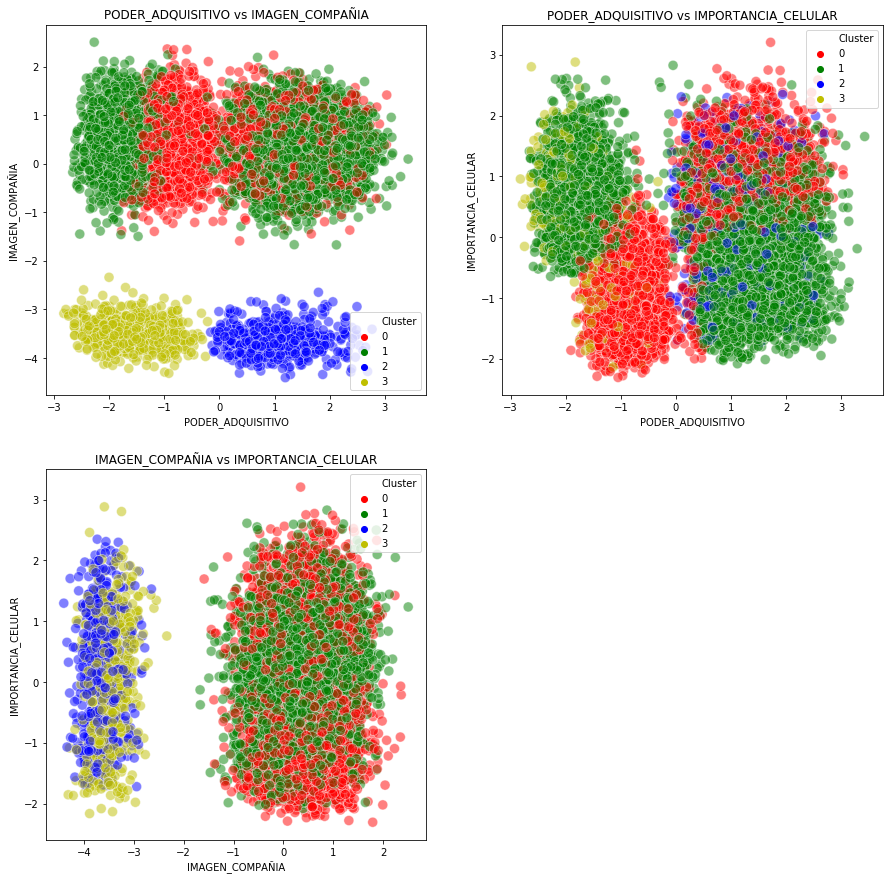

single


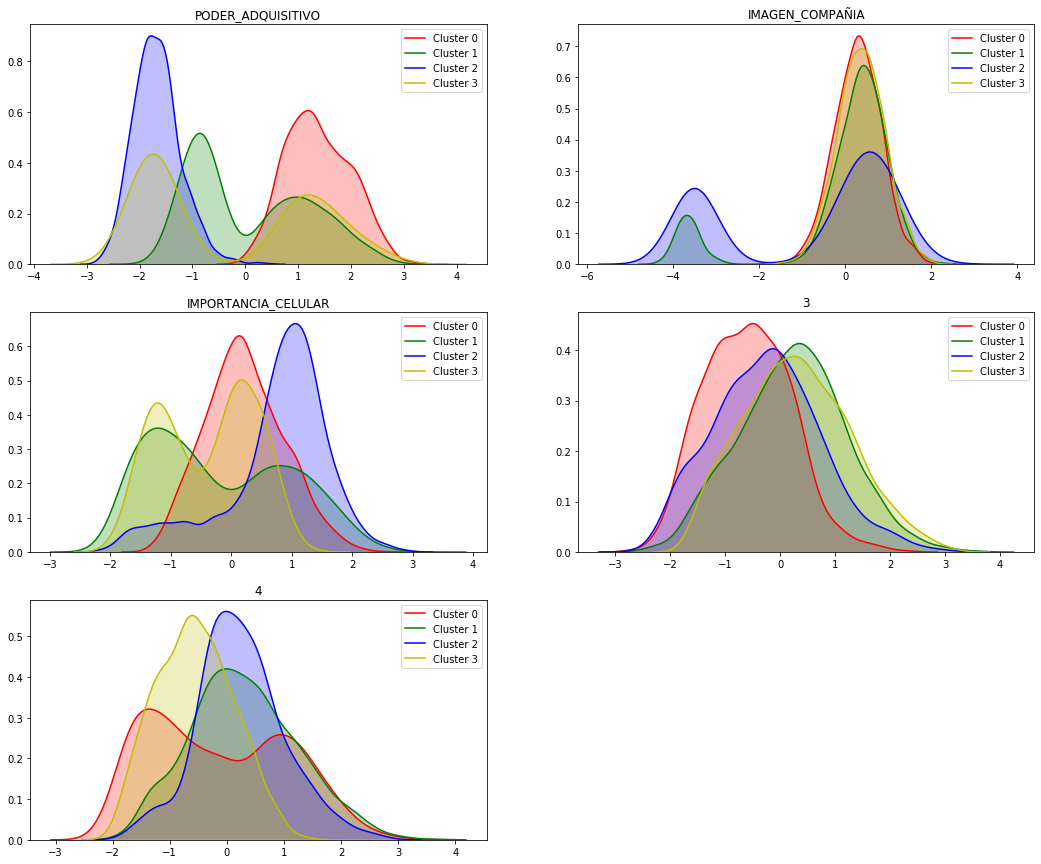

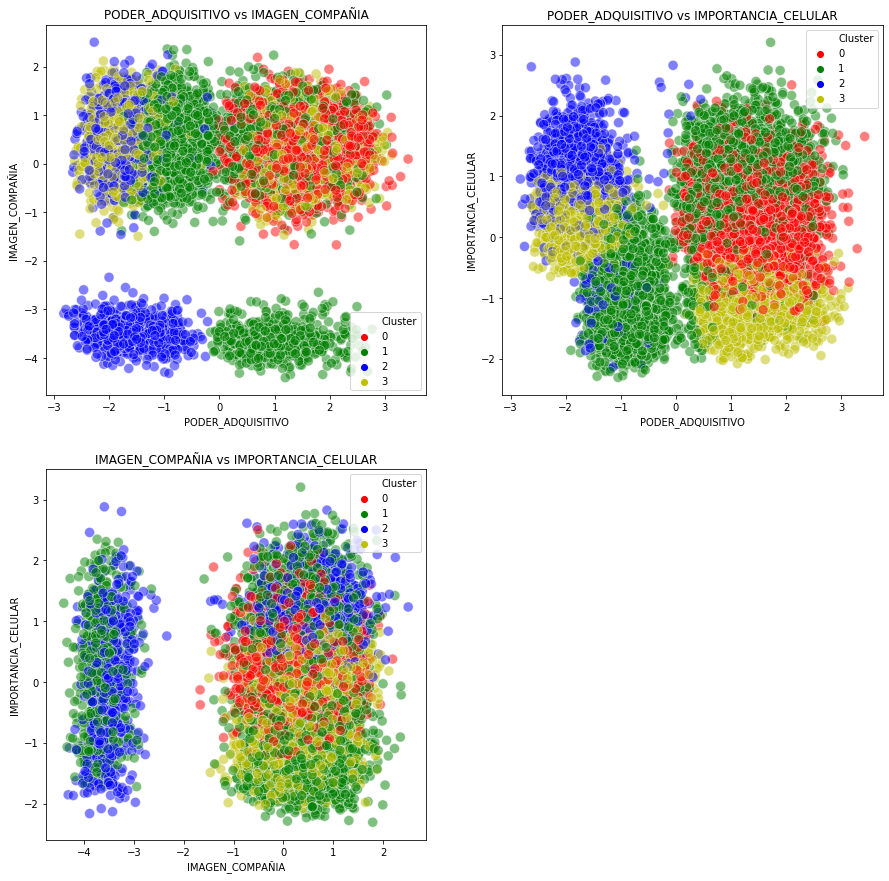

centroid


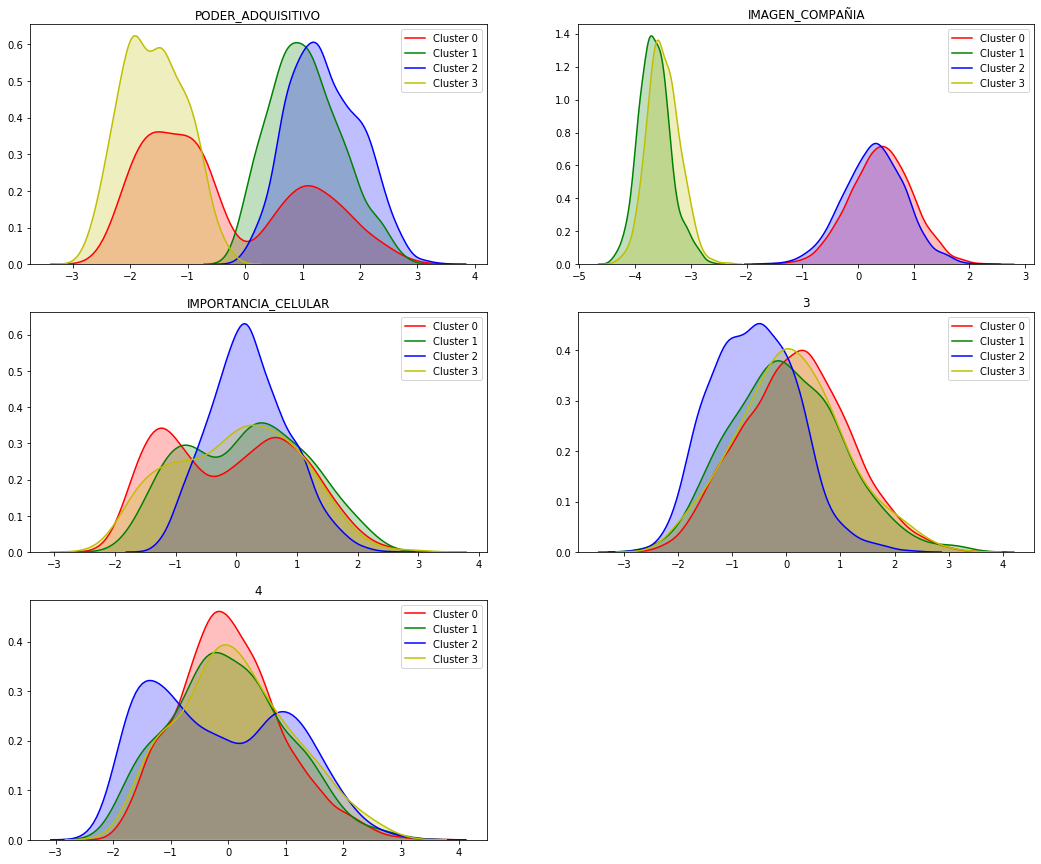

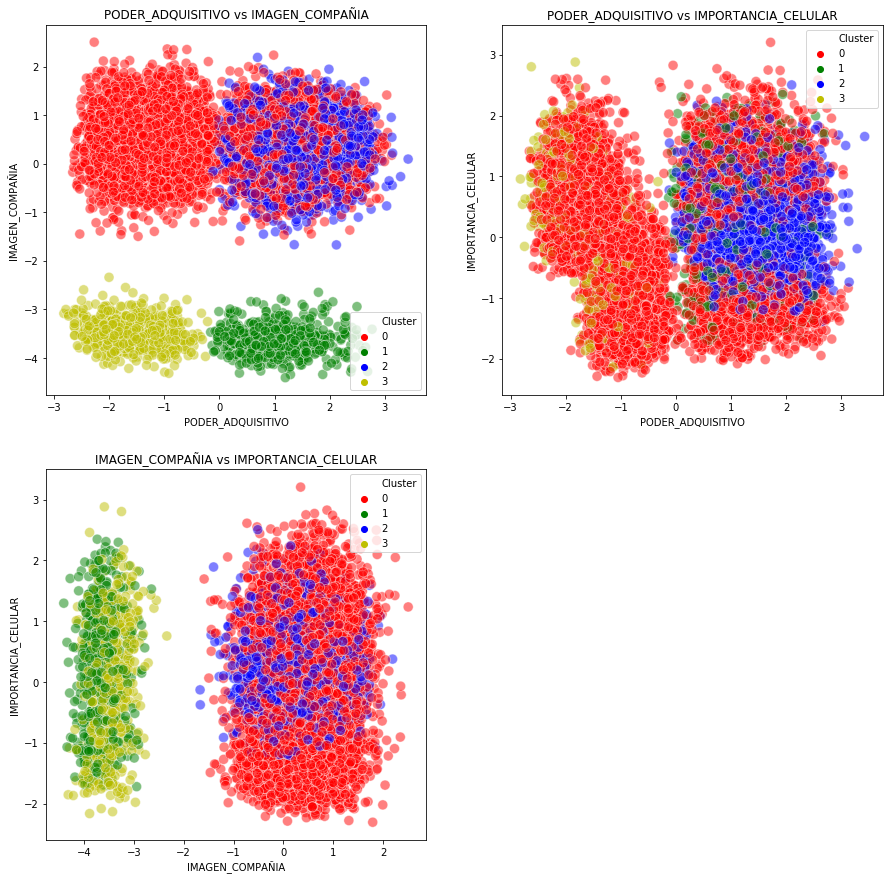

weighted


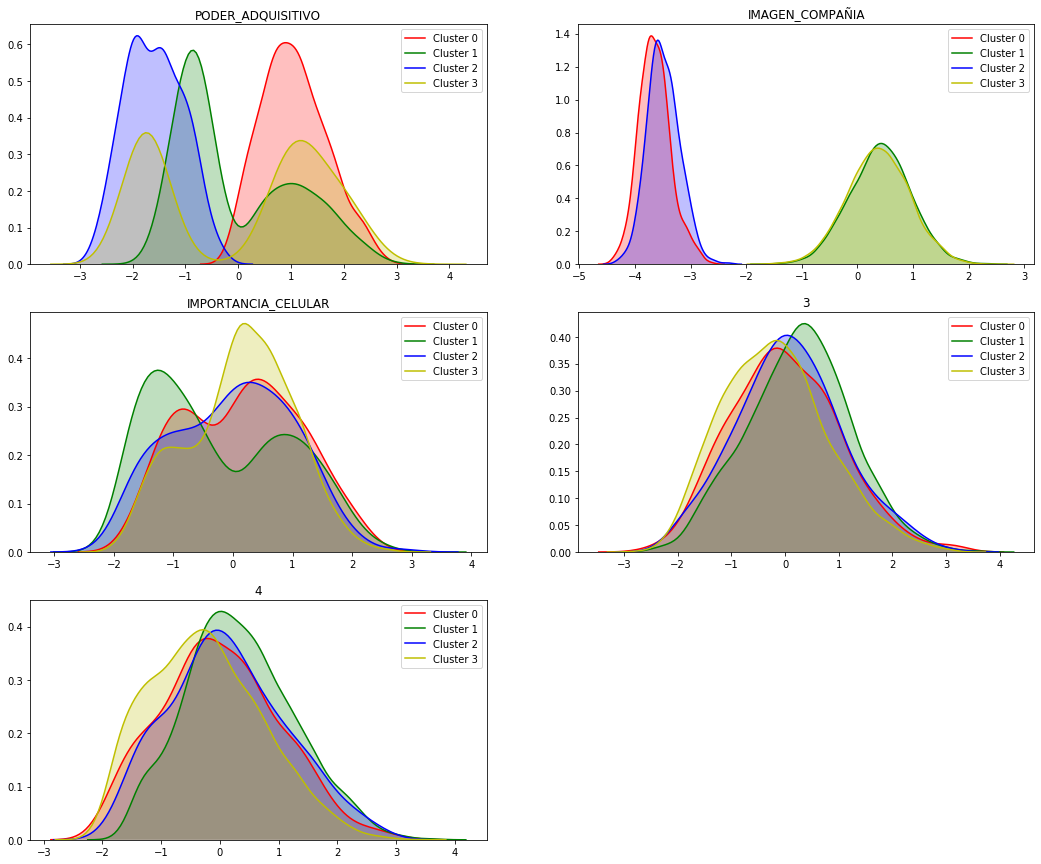

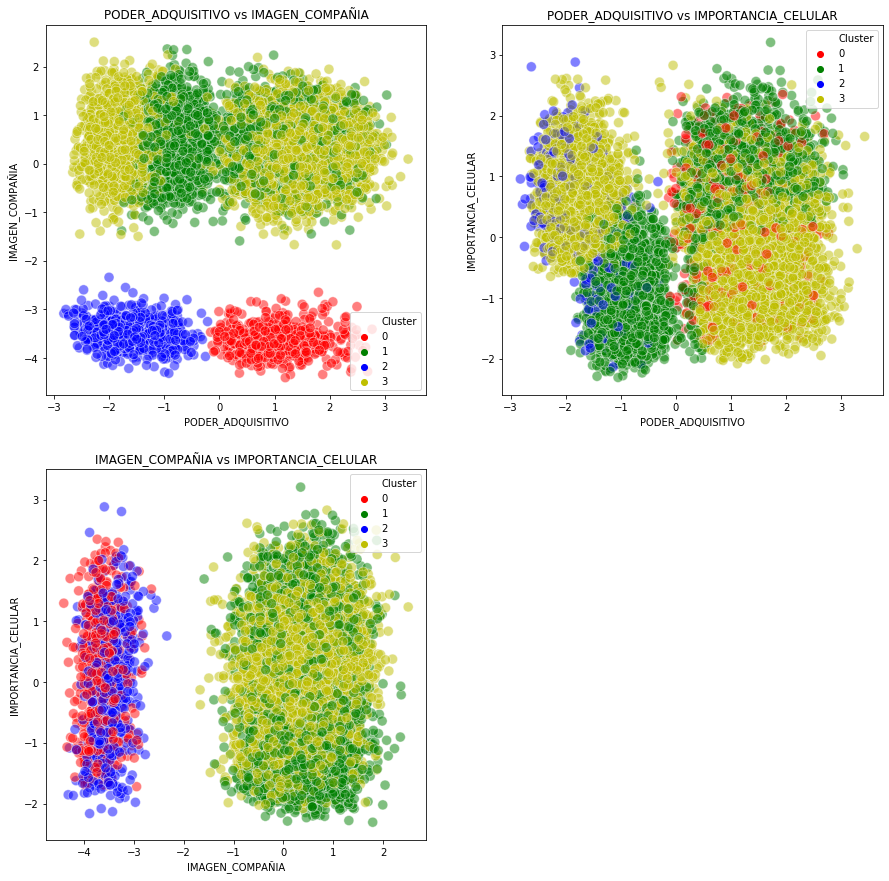

In [444]:
for link in all_fusiones.keys():
    print(link)
    plot_clusters_1D(clusterize(link, 4, df_ret_proyectado_drop_cols),4,var_num)
    plot_clusters_2D(clusterize(link, 4, df_ret_proyectado_drop_cols),['PODER_ADQUISITIVO','IMAGEN_COMPAÑIA','IMPORTANCIA_CELULAR'],2,2,4)

Lus clusters con clustering jerárquico parecen más difíciles de interpretar: si bien se podría hacer ciertos análisis sobre varios para determinar lo que significa cada cluster, son muchas las combinaciones de valores de variables que habría que hacer para determinar la separación de cada cluster. Es algo difícil de visualizar en 2 dimensiones los clusters. Aún así, aplicaremos silueta sobre los 3 métodos de cálculo de distancia que mejor comportamiento mostraron para ver que tan bueno fue el cluster.

In [441]:
selected_links = ['ward','average', 'centroid', 'weighted']